In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [34]:
data=pd.read_csv('C:/Users/Biranchi/Desktop/Internship/Projects/Project_2/messages.csv')
data

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [35]:
print("Shape of the data is: ",data.shape)

Shape of the data is:  (2893, 3)


In [36]:
#Checking data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
subject    2831 non-null object
message    2893 non-null object
label      2893 non-null int64
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


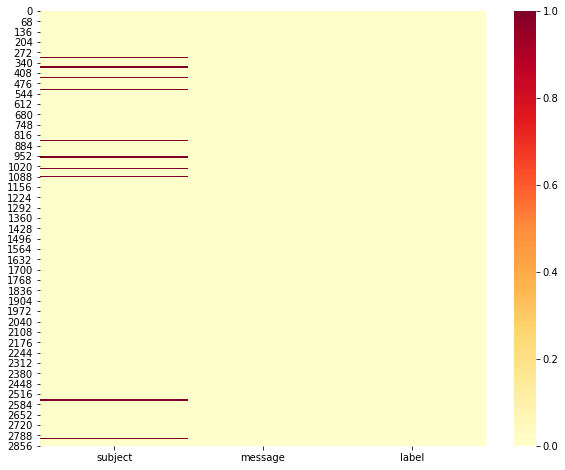

In [37]:
nans=data.isna()
plt.figure(figsize=(10,8))
sns.heatmap(nans,cmap='YlOrRd')

In [38]:
#Checking nan values
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [39]:
#In 62 observations subject is missing

In [40]:
#Statistical Summary
data.describe(include='all')

,subject,message,label
count,2831,2893,2893.000000
unique,2613,2859,NaN
top,sociolinguistics,this is not spam ; you are receiving this mess...,NaN
freq,8,5,NaN
mean,NaN,NaN,0.166263
std,NaN,NaN,0.372381
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


In [41]:
data.label.value_counts()

0    2412
1     481
Name: label, dtype: int64

In [42]:
#Checking percentages of spam and ham
print("Ham: ",round(len(data[data.label==0])/len(data.label),2)*100," %")
print("Spam: ",round(len(data[data.label==1])/len(data.label),2)*100," %")

Ham:  83.0  %
Spam:  17.0  %


In [43]:
#Subject may be same but we drop the columns having same message
data.message.drop_duplicates(inplace=True)
data.shape

(2893, 3)

In [44]:
#Treating nan by back fill
data['subject'].fillna(method='bfill',inplace=True)

In [45]:
data.isna().sum()

subject    0
message    0
label      0
dtype: int64

In [46]:
#adding subject and message length column
data['sub_len']=data['subject'].str.len()
data['msg_len']=data['message'].str.len()
data.head()

,subject,message,label,sub_len,msg_len
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,39,2856
1,query : letter frequencies for text identifica...,"lang classification grimes , joseph e . and ba...",0,50,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046


In [47]:
#Converting to Lower case
data['subject']=data['subject'].str.lower()
data['message']=data['message'].str.lower()

In [48]:
#Removing Stopwords from both the columns
stop_words=stopwords.words('english')

data['subject']=data['subject'].apply(lambda x: ' '.join(
word for word in x.split() if word not in stop_words))

data['message']=data['message'].apply(lambda x: " ".join(
word for word in x.split() if word not in stop_words))

In [49]:
#Removing punctuations
data.subject=data.subject.str.replace(r'[^\w\d\s]', " ")

data.message=data.message.str.replace(r'[^\w\d\s]'," ")

data.head()

,subject,message,label,sub_len,msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435
3,risk,colleague researching differing degrees risk p...,0,4,324
4,request book information,earlier morning phone friend mine living south...,0,24,1046


In [50]:
#Removing more than one leading and trailing spaces
data.subject=data.subject.str.replace(r'^s+|s+?$', " ")

data.message=data.message.str.replace(r'^s+|s+?$', " ")

#Removing leading and trailing tabs

data.subject=data.subject.str.replace(r'^t+|t+?$', " ")

data.message=data.message.str.replace(r'^t+|t+?$', " ")

data.head()

,subject,message,label,sub_len,msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435
3,risk,colleague researching differing degrees risk p...,0,4,324
4,request book information,earlier morning phone friend mine living south...,0,24,1046


In [51]:
#Checking length of the cleaned columns
data['Cleaned_sub_len']=data.subject.str.len()

data['Cleaned_msg_len']=data.message.str.len()

data.head()

,subject,message,label,sub_len,msg_len,Cleaned_sub_len,Cleaned_msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856,39,2487
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800,46,1571
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435,46,1144
3,risk,colleague researching differing degrees risk p...,0,4,324,4,220
4,request book information,earlier morning phone friend mine living south...,0,24,1046,24,719


In [52]:
print("Subject Length before cleaning: ",data.sub_len.sum(),"  After clean: ",data.Cleaned_sub_len.sum())
print("Message Length before cleaning: ",data.msg_len.sum(),"  After clean: ",data.Cleaned_msg_len.sum())

Subject Length before cleaning:  93742   After clean:  84255
Message Length before cleaning:  9344743   After clean:  7551954


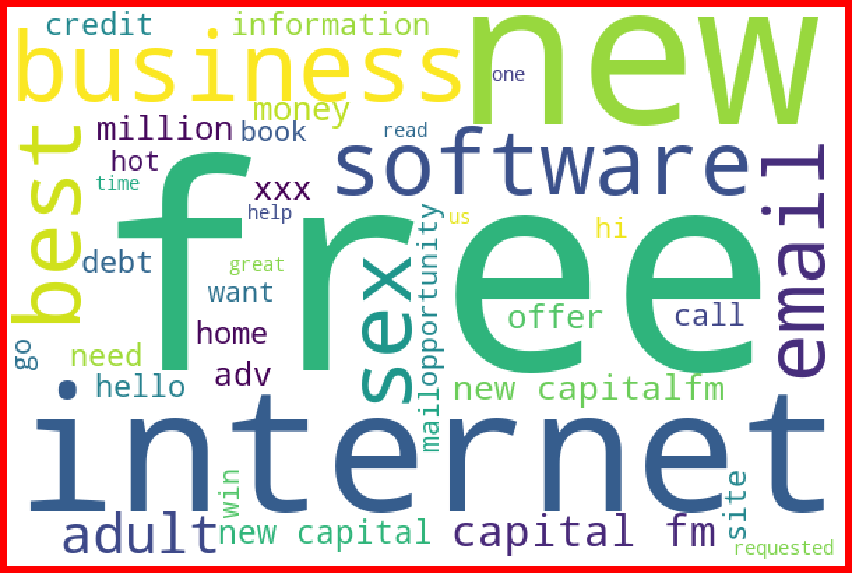

In [53]:
#We see some loud words used for spam message subject
spam_sub=data['subject'][data['label']==1]

spam_sub_cloud=WordCloud(width=600,height=400,background_color='white',max_words=40).generate(' '.join(spam_sub))
plt.figure(figsize=(12,10),facecolor='r')
plt.imshow(spam_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

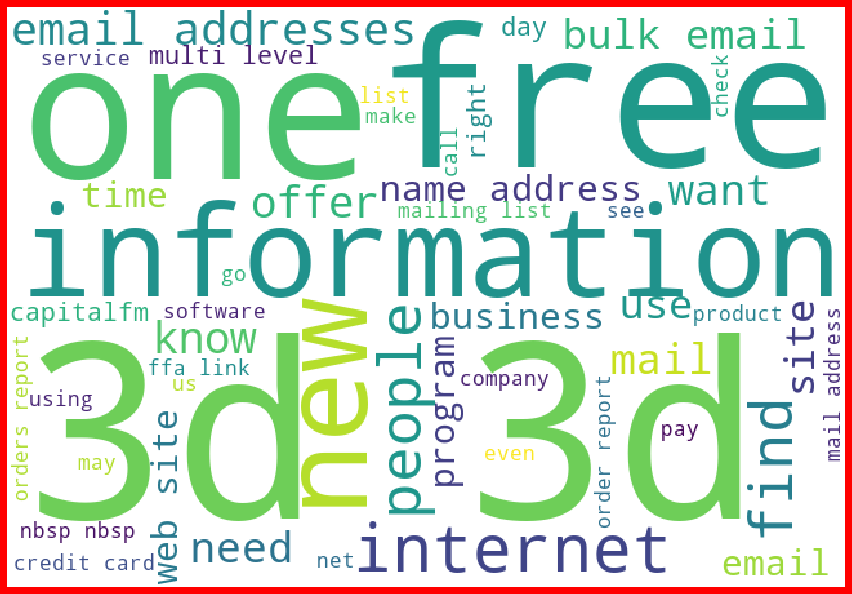

In [54]:
#We see some loud words used for spam message 
spam_msg=data['message'][data['label']==1]

spam_sub_cloud=WordCloud(width=650,height=450,background_color="white",max_words=50).generate(' '.join(spam_msg))
plt.figure(figsize=(12,10),facecolor='r')
plt.imshow(spam_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

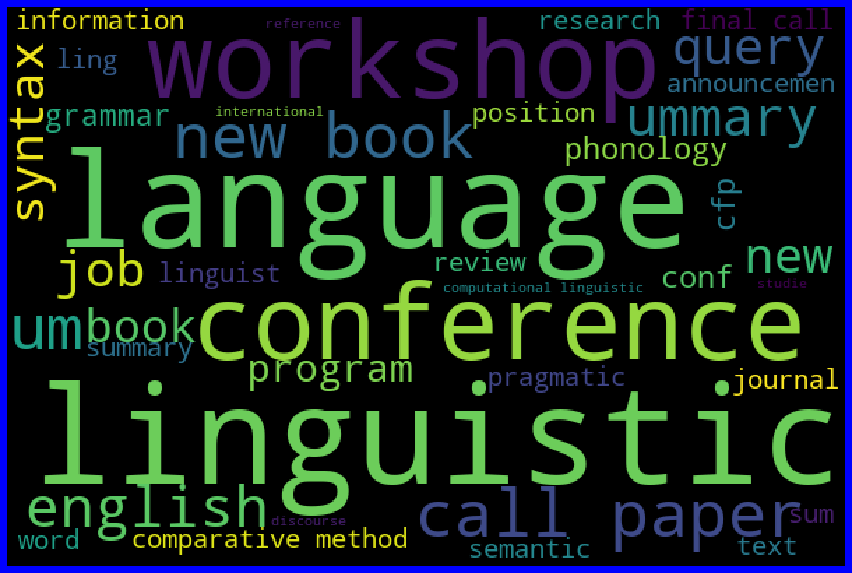

In [55]:
#some Loud words used for ham message subject
ham_sub=data['subject'][data['label']==0]

ham_sub_cloud=WordCloud(width=600,height=400,max_words=40).generate(' '.join(ham_sub))
plt.figure(figsize=(12,10),facecolor='b')
plt.imshow(ham_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

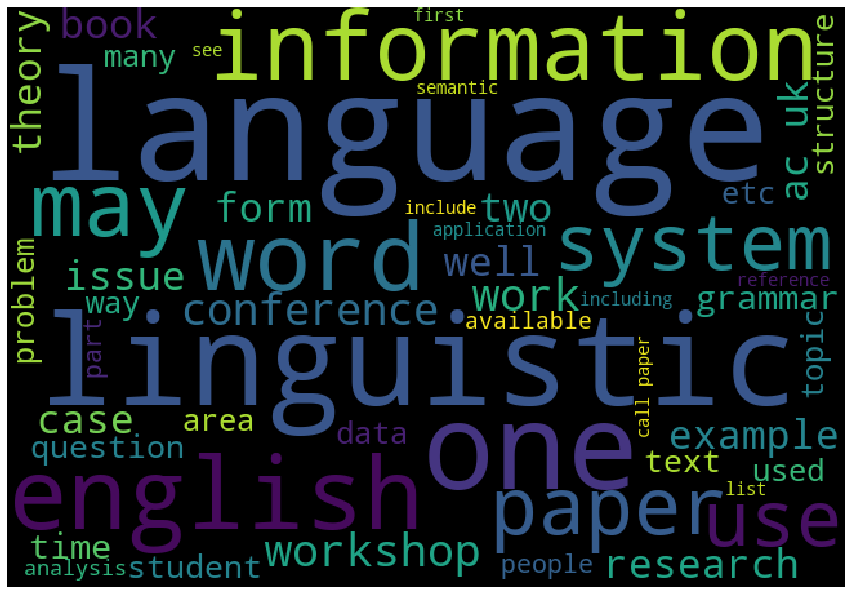

In [56]:
#Some Loud Words used for ham message
ham_msg=data['message'][data['label']==0]

ham_msg_cloud=WordCloud(width=650,height=450,max_words=50).generate(' '.join(ham_msg))
plt.figure(figsize=(12,10))
plt.imshow(ham_msg_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [57]:
data.head()

,subject,message,label,sub_len,msg_len,Cleaned_sub_len,Cleaned_msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856,39,2487
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800,46,1571
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435,46,1144
3,risk,colleague researching differing degrees risk p...,0,4,324,4,220
4,request book information,earlier morning phone friend mine living south...,0,24,1046,24,719


In [58]:
#The data is cleaned and can be vectorized to perform machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()

data.subject=tfidf.fit_transform(data.subject)

data.message=tfidf.fit_transform(data.message)

x=data.iloc[:,0:2]
y=data['label']

Machine Learning to detect spam emails

In [59]:
#Checking for best random state
max_acc_scr=0
for r_state in range(42,101):
    train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=r_state,test_size=0.25)
    mnb=MultinomialNB()
    mnb.fit(train_x,train_y)
    pred=mnb.predict(test_x)
    acc_scr=accuracy_score(pred,test_y)
    if acc_scr>max_acc_scr:
        max_acc_scr=acc_scr
        final_r_state=r_state
    print('Max Accuracy score corresponding to ',final_r_state,' is ',max_acc_scr)    

ValueError: setting an array element with a sequence.

In [60]:
#spliting the dataset taking random state= 43
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=43,test_size=0.25)
#Checking The best model
model=[LogisticRegression(),KNeighborsClassifier(),SVC(),DecisionTreeClassifier()]
for m in model:
    m.fit(train_x,train_y)
    predm=m.predict(test_x)
    print('Model :',m)
    print('Accuracy Score: ',accuracy_score(predm,test_y),"\n")
    print("Confusion Matrix: \n",confusion_matrix(predm,test_y),"\n")
    print('Classification Report: \n',classification_report(predm,test_y))
    print("*****************************************")

ValueError: setting an array element with a sequence.